## Imports and settings

In [1]:
# Fix randomness and hide warnings
seed = 1234

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras
from keras import backend
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [3]:
# Check if tensorflow is using GPU
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
import my_utils
import albumentations as A

## Load the data

In [5]:
T1_samples_loaded, T2_samples_loaded, T1_labels_loaded, T2_labels_loaded = my_utils.load_preprocessed_data_train()

## Prepare the data for the network

In [6]:
T1_data_samples, T2_data_samples, T1_data_labels, T2_data_labels = my_utils.prepare_data_for_training(T1_samples_loaded, T2_samples_loaded, T1_labels_loaded, T2_labels_loaded)

Preparing T1 samples for training...
- Vertically stacking the samples from all patients...
- Adding a channel dimension to the samples...
- Normalizing the samples with min-max scaling...
Samples shape: (640, 272, 272, 1)

Preparing T2 samples for training...
- Vertically stacking the samples from all patients...
- Adding a channel dimension to the samples...
- Normalizing the samples with min-max scaling...
Samples shape: (640, 272, 272, 1)

Preparing T1 labels for training...
- Vertically stacking the labels from all patients...
- Creating masks for the different categories...
Labels shape: (640, 272, 272, 1)

Preparing T2 labels for training...
- Vertically stacking the labels from all patients...
- Creating masks for the different categories...
Labels shape: (640, 272, 272, 1)


In [7]:
# Vertically stack the T1 and T2 data (samples and labels)
data_samples = np.vstack((T1_data_samples, T2_data_samples))
data_labels = np.vstack((T1_data_labels, T2_data_labels))

# Print the shape of the data
print(data_samples.shape)
print(data_labels.shape)

(1280, 272, 272, 1)
(1280, 272, 272, 1)


In [8]:
# Split the data into training, validation and test sets
X_train, X_val, X_test, y_train, y_val, y_test = my_utils.split_data_for_training(data_samples, data_labels)

Splitting the data into training, validation and test sets...
    Train samples shape: (880, 272, 272, 1)
    Train labels shape: (880, 272, 272, 1)
    Validation samples shape: (200, 272, 272, 1)
    Validation labels shape: (200, 272, 272, 1)
    Test samples shape: (200, 272, 272, 1)
    Test labels shape: (200, 272, 272, 1)


In [9]:
input_shape = X_train[0].shape
num_classes = len(np.unique(y_train))
print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (272, 272, 1)
Number of classes: 5


## Create the model and a custom IOU metric

In [10]:
# Create the UNet model
model = my_utils.get_unet_model(input_shape=T1_data_samples[0].shape, num_classes=len(np.unique(T1_data_labels)))
model.summary()

Model: "unet_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 272, 272, 1)]        0         []                            
                                                                                                  
 down_block1_conv1 (Conv2D)  (None, 272, 272, 64)         640       ['input_layer[0][0]']         
                                                                                                  
 down_block1_bn1 (BatchNorm  (None, 272, 272, 64)         256       ['down_block1_conv1[0][0]']   
 alization)                                                                                       
                                                                                                  
 down_block1_act1 (Activati  (None, 272, 272, 64)         0         ['down_block1_bn1[0][

In [11]:
# Define a custom metric class for mean intersection over union (IoU)
@keras.utils.register_keras_serializable()
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes=None, name="mean_iou", dtype=None):
        super(UpdatedMeanIoU, self).__init__(num_classes=num_classes, name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

## Create a data augmentation pipeline

In [12]:
class CustomDataGenerator(keras.utils.Sequence):
    def __init__(self, data, labels, batch_size, augmentations=None):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.augmentations = augmentations
        self.indexes = np.arange(len(self.data))

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size

        # Handle the last batch if it doesn't evenly divide the dataset length
        if end > len(self.data):
            end = len(self.data)

        batch_data = self.data[start:end]
        batch_labels = self.labels[start:end]

        augmented_data = []
        augmented_labels = []

        for data_item, label_item in zip(batch_data, batch_labels):
            if self.augmentations:

                # Convert data to float32 and labels to int32 for best performance
                data_item = data_item.astype(np.float32)
                label_item = label_item.astype(np.int32)
                
                # Apply augmentations to the image and mask
                augmented = self.augmentations(image=data_item, mask=label_item)
                data_item = augmented['image']
                label_item = augmented['mask']

            augmented_data.append(data_item)
            augmented_labels.append(label_item)

        # Convert the list of augmented images and labels to a numpy array
        augmented_data = np.array(augmented_data)
        augmented_labels = np.array(augmented_labels)

        return augmented_data, augmented_labels


In [13]:
# Define a function to convert images to uint8 and back to float32
def to_uint8(image, **kwargs):
    return (image * 255).astype('uint8')

def to_float32(image, **kwargs):
    return image.astype('float32') / 255.0

# Create the data augmentation pipeline
augmentation_pipeline = A.Compose([
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.Lambda(image=to_uint8),
    A.Equalize(p=0.5),
    A.Lambda(image=to_float32),
    A.GaussNoise(var_limit=(0.0, 5.0), p=0.5),
    A.Blur(blur_limit=(3,4), p=0.5)
])

## Train the model

In [14]:
# Free up RAM
del T1_samples_loaded, T2_samples_loaded, T1_labels_loaded, T2_labels_loaded, T1_data_samples, T2_data_samples, T1_data_labels, T2_data_labels, data_samples, data_labels

In [15]:
# Define input parameters
input_shape = X_train[0].shape
num_classes = len(np.unique(y_train))

# Define hyperparameters
learning_rate = 5e-4
batch_size = 8
epochs = 350

# Define compile parameters
loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
metrics = ['accuracy', UpdatedMeanIoU(num_classes=num_classes)]

In [16]:
# Train the model on training and validation data together
new_X_train = np.vstack((X_train, X_val))
new_y_train = np.vstack((y_train, y_val))

In [17]:
# Instantiate the data generator
data_generator = CustomDataGenerator(new_X_train, new_y_train, batch_size=batch_size, augmentations=augmentation_pipeline)

In [18]:
# Compile the model
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [20]:
# Train the model
history = model.fit(
    data_generator,
    batch_size=batch_size,
    epochs=epochs
)

Epoch 1/350


I0000 00:00:1703124022.158777   29805 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


135/135 [==============================] - 80s 242ms/step - loss: 0.2958 - accuracy: 0.9725 - mean_iou: 0.1907
Epoch 2/350
135/135 [==============================] - 32s 235ms/step - loss: 0.1765 - accuracy: 1.0000 - mean_iou: 0.1922
Epoch 3/350
135/135 [==============================] - 31s 231ms/step - loss: 0.1723 - accuracy: 1.0000 - mean_iou: 0.1922
Epoch 4/350
135/135 [==============================] - 31s 229ms/step - loss: 0.1728 - accuracy: 1.0000 - mean_iou: 0.1922
Epoch 5/350
135/135 [==============================] - 33s 241ms/step - loss: 0.1722 - accuracy: 1.0000 - mean_iou: 0.1922
Epoch 6/350
135/135 [==============================] - 33s 243ms/step - loss: 0.1742 - accuracy: 1.0000 - mean_iou: 0.1922
Epoch 7/350
135/135 [==============================] - 32s 240ms/step - loss: 0.1701 - accuracy: 1.0000 - mean_iou: 0.1922
Epoch 8/350
135/135 [==============================] - 33s 244ms/step - loss: 0.1594 - accuracy: 1.0000 - mean_iou: 0.1922
Epoch 9/350
135/135 [=======

## Visualize the results

1/1 [==============================] - 4s 4s/step


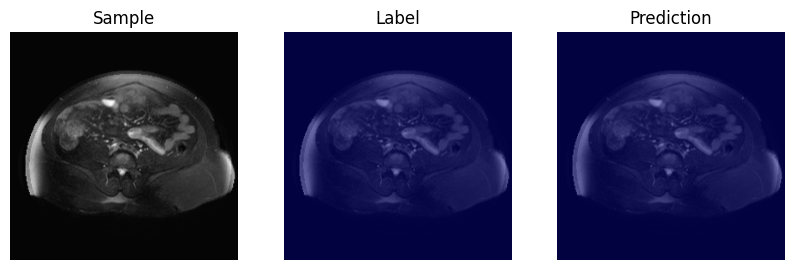

1/1 [==============================] - 0s 16ms/step


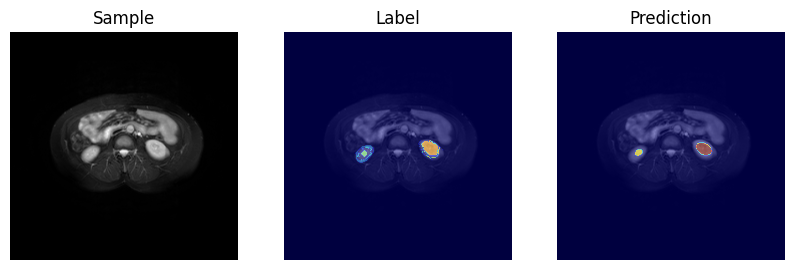

1/1 [==============================] - 0s 16ms/step


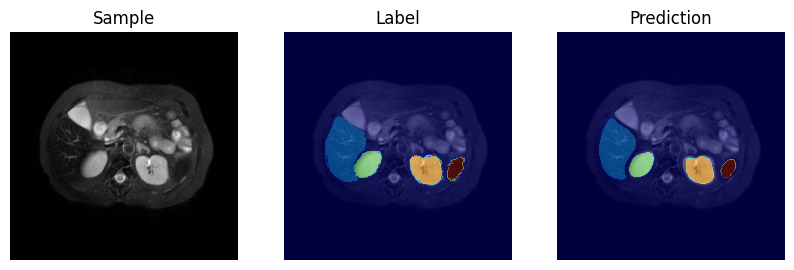

1/1 [==============================] - 0s 15ms/step


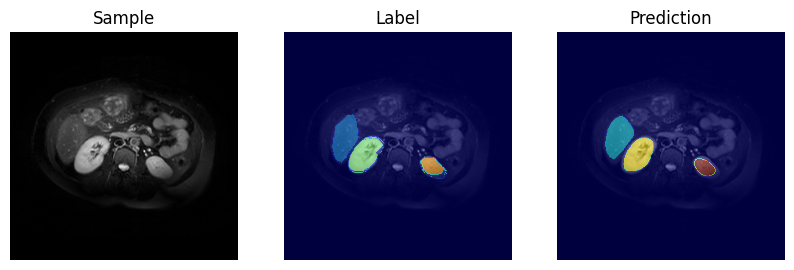

1/1 [==============================] - 0s 15ms/step


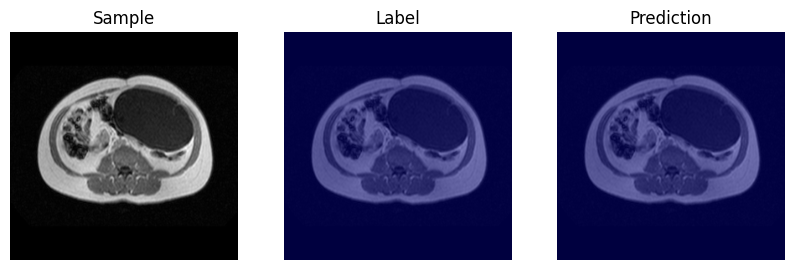

In [22]:
# Find a couple interesting samples to visualize
sample_indices = [1, 2, 3, 4, 7]

for sample_index in sample_indices:
    sample = X_test[sample_index]
    label = y_test[sample_index]

    # Plot the prediction and label
    my_utils.plot_prediction(model, sample, label, figsize=(10, 10))

## Save and load the model

In [23]:
# Save the model and its weights
model.save('models/unet_final.keras')
model.save_weights('models/unet_final_weights.keras')

In [25]:
# Create a new model and load the weights
new_model = my_utils.get_unet_model(input_shape=input_shape, num_classes=num_classes)
new_model.load_weights('models/unet_final_weights.keras')

# Compile the new model
new_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', UpdatedMeanIoU(num_classes=num_classes)])

# Evaluate the new model on the test set and print results
loss, accuracy, mean_iou = new_model.evaluate(X_test, y_test, batch_size=batch_size)

print(f"Test Loss:\t{loss}")
print(f"Test Accuracy:\t{accuracy}")
print(f"Test Mean IoU:\t{mean_iou}")

25/25 [==============================] - 4s 135ms/step - loss: 0.0221 - accuracy: 0.9927 - mean_iou: 0.7895
Test Loss:	0.022069741040468216
Test Accuracy:	0.9927389025688171
Test Mean IoU:	0.7894912958145142
